# <center> 데이터사이언스개론 </center>
## <center> Gradient Descent 실습 과제 </center>

<div class="pull-right"> 컴퓨터공학과 201811259 배수빈 </div>

## 0-1 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql
import statsmodels.api as sm
from celluloid import Camera
from IPython.display import HTML

## 0-2. db_score 디비로 구축

In [2]:
def load_score_data():
    file = "C:\\Users\\Subin\\db_score.xlsx"
    score = pd.read_excel(file) 
    
    conn = pymysql.connect(host='localhost', user = 'root', password = 'dbsrl9339^^', db = 'university')
    curs = conn.cursor(pymysql.cursors.DictCursor)

    drop_sql = """drop table if exists db_score"""
    
    import sqlalchemy
    database_username = 'root'
    database_password = 'dbsrl9339^^'
    database_ip = 'localhost'
    database_name = 'university'
    database_connection = sqlalchemy.create_engine('mysql+pymysql://{0}:{1}@{2}/{3}'.format(database_username, database_password, 
                                                                                             database_ip, database_name))
    score.to_sql(con = database_connection, name = 'db_score', if_exists = 'replace')
                                                                                            
load_score_data()                                                                              

-----


## 1. Simple linear regression 시각화

#### 1-1. DB에서 데이터 꺼내서 X, y 에 저장

In [3]:
def load_dbscore_data():
    conn = pymysql.connect(host='localhost', user = 'root', password = 'dbsrl9339^^', db = 'university')
    curs = conn.cursor(pymysql.cursors.DictCursor)
    
    sql = "select * from db_score"
    curs.execute(sql)
    
    data  = curs.fetchall()
    
    curs.close()
    conn.close()
    
    X = [ ( t['midterm'] ) for t in data ]
    X = np.array(X)
    
    y = [ (t['score']) for t in data]
    y = np.array(y)

    return X, y

X, y = load_dbscore_data()

#### 1-2. 경사하강법을 활용한 선형회귀

epoch 0: m_grad=-3227.859378, c_grad=-128.088261, m=3.227859, c=0.128088
epoch 1000: m_grad=0.152477, c_grad=-3.995112, m=2.441183, c=4.530306
epoch 2000: m_grad=0.124641, c_grad=-3.265779, m=2.303106, c=8.148144
epoch 3000: m_grad=0.101887, c_grad=-2.669590, m=2.190235, c=11.105523
epoch 4000: m_grad=0.083287, c_grad=-2.182239, m=2.097970, c=13.523012
epoch 5000: m_grad=0.068082, c_grad=-1.783857, m=2.022548, c=15.499174
epoch 6000: m_grad=0.055653, c_grad=-1.458203, m=1.960895, c=17.114574
epoch 7000: m_grad=0.045494, c_grad=-1.191998, m=1.910497, c=18.435073
epoch 8000: m_grad=0.037188, c_grad=-0.974391, m=1.869300, c=19.514506
epoch 9000: m_grad=0.030399, c_grad=-0.796510, m=1.835623, c=20.396882
epoch 10000: m_grad=0.024850, c_grad=-0.651102, m=1.808094, c=21.118175
epoch 11000: m_grad=0.020313, c_grad=-0.532239, m=1.785591, c=21.707790
epoch 12000: m_grad=0.016605, c_grad=-0.435075, m=1.767196, c=22.189768
epoch 13000: m_grad=0.013574, c_grad=-0.355650, m=1.752159, c=22.583757
ep

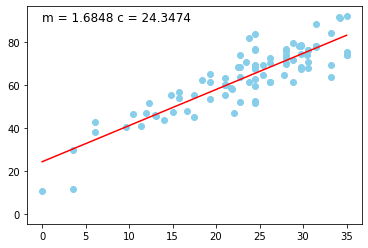

In [4]:
def gradient_descent_vectorized(X, y):
    epochs = 100000
    min_grad = 0.0001
    learning_rate = 0.001
    
    m = 0.0
    c = 0.0
    
    n = len(y)
    
    c_grad = 0.0
    m_grad = 0.0
    
    fig, ax = plt.subplots()
    camera = Camera(fig)
    
    for epoch in range(epochs):    
        y_pred = m * X + c 
        m_grad = (2*(y_pred - y)*X)
        m_grad = m_grad.sum()/n
        c_grad = (2 * (y_pred - y)).sum()/n
        
        m = m - learning_rate * m_grad
        c = c - learning_rate * c_grad  

        if ( epoch % 1000 == 0): 
            print("epoch %d: m_grad=%f, c_grad=%f, m=%f, c=%f" %(epoch, m_grad, c_grad, m, c) )

            
            ax.scatter(X, y, color = 'skyblue')
            ax.plot([min(X), max(X)], [min(y_pred), max(y_pred)], color='red') # plot 선
            ax.annotate("m = %.4f c = %.4f " %(m, c), xy = (0, 90), fontsize = 12)
            camera.snap()
            fig

        if ( abs(m_grad) < min_grad and abs(c_grad) < min_grad ):
            break
    animation = camera.animate()
    HTML(animation.to_html5_video())
    animation.save("[데이터사이언스]GD_visualize.mp4")
    return m, c

a , b = gradient_descent_vectorized(X, y)
print( "최종 m : %.4f  /   c : %.4f" %(a, b))

- 최종적으로 경사하강법으로 알아낸 기울기와 절편은 위와 같이 기울기는 1.6848, 절편은 24.3475와 같다. 
- 동영상을 보면 알 수 있듯이, 기울기와 절편 모두 에포크가 증가하면서 점점 산점도의 점들의 분포와 근접해감을 알 수 있다. 

------

## 2. multiple linear regression 구현

#### 2-1. DB에서 데이터 꺼내서 X, y 에 저장

In [5]:
def load_dbscore_data():
    conn = pymysql.connect(host='localhost', user = 'root', password = 'dbsrl9339^^', db = 'university')
    curs = conn.cursor(pymysql.cursors.DictCursor)
    
    sql = "select * from db_score"
    curs.execute(sql)
    
    data  = curs.fetchall()
    
    curs.close()
    conn.close()
    
    X = [ (t['attendance'], t['homework'], t['midterm'] ) for t in data ]
    X = np.array(X)
    
    y = [ (t['score']) for t in data]
    y = np.array(y)

    return X, y

X, y = load_dbscore_data()

#### 2-2. LS

In [6]:
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const)
ls = model.fit()


ls_c = ls.params[0] # c ( y절편 )
ls_m = ls.params[1] # m ( 기울기 )

print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     131.2
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           2.24e-32
Time:                        17:58:08   Log-Likelihood:                -302.25
No. Observations:                  92   AIC:                             612.5
Df Residuals:                      88   BIC:                             622.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.4116     15.824     -1.227      0.2

#### 2-3. 경사하강법을 활용한 선형회귀

In [7]:
def gradient_descent_vectorized(X, y):
    epochs = 1000000
    min_grad = 0.0001
    learning_rate = 0.001
    
    m = [0.0, 0.0, 0.0]
    m = np.array(m)
    
    c = 0.0
    n = len(y)
    c_grad = 0.0    
    m_grad = [0.0, 0.0, 0.0]
    m_grad = np.array(m_grad)
    
    for epoch in range(epochs):    
        y_pred = m[0]*X[:,0] + m[1]*X[:,1] + m[2]*X[:,2] + c

        m_grad[0] = (2*(y_pred - y)*X[:,0]).sum()/n
        m_grad[1] = (2*(y_pred - y)*X[:,1]).sum()/n
        m_grad[2] = (2*(y_pred - y)*X[:,2]).sum()/n
        c_grad = (2 * (y_pred - y)).sum()/n
        
        m[0] = m[0] - learning_rate * m_grad[0]
        m[1] = m[1] - learning_rate * m_grad[1]
        m[2] = m[2] - learning_rate * m_grad[2]
        
        c = c - learning_rate * c_grad
        
        if ( epoch % 100000 == 0):
           # print(m)
            print("epoch %d: c_grad=%f, c=%f / %f   %f   %f" %(epoch, c_grad, c, m[0], m[1], m[2]) )
            
        if ( abs(m_grad[0]) and abs(m_grad[1]) and abs(m_grad[2]) < min_grad and
            abs(c_grad) < min_grad ):
            break

    return m, c

a, b = gradient_descent_vectorized(X, y)
print( "기을기 : %.4f    /    %.4f    /    %.4f" %(a[0], a[1], a[2]))
print( "절편 : %.4f" %b)

epoch 0: c_grad=-128.088261, c=0.128088 / 1.003714   2.385090   3.227859
epoch 100000: c_grad=0.050240, c=-5.920524 / 2.080996   0.974666   1.524609
epoch 200000: c_grad=0.034620, c=-10.115163 / 2.655727   0.961283   1.522332
epoch 300000: c_grad=0.023856, c=-13.005607 / 3.051764   0.952060   1.520764
epoch 400000: c_grad=0.016439, c=-14.997355 / 3.324664   0.945705   1.519683
epoch 500000: c_grad=0.011327, c=-16.369830 / 3.512715   0.941326   1.518938
epoch 600000: c_grad=0.007806, c=-17.315576 / 3.642297   0.938308   1.518424
epoch 700000: c_grad=0.005379, c=-17.967271 / 3.731590   0.936229   1.518071
epoch 800000: c_grad=0.003706, c=-18.416342 / 3.793119   0.934796   1.517827
epoch 900000: c_grad=0.002554, c=-18.725788 / 3.835518   0.933808   1.517659
기을기 : 3.8647    /    0.9331    /    1.5175
절편 : -18.9390


|  | LS | 경사하강법 |
| :---: | :----: | :----: |
| 절편 | -19.4116 | -18.9390|
| 기울기 1 | 3.9295 | 3.8647  |
| 기울기 2 | 0.9316 | 0.9331  |
| 기울기 3 | 1.5173 | 1.5175  |

- LS와 경사하강법을 통해 얻어낸 기울기와 절편이 유사함을 알 수 있다. 